# What affects road safety in the UK?  


**Import note book instructions**

In [25]:
# For data analysis
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime as dt
import math
import seaborn as sns
import time
import random
import json
import pickle
import itertools  

# For data acquisition
import csv
import os
import requests
import urllib.request
import zipfile
#import networkx as nx

# For ploting
#!pip install plotly_express
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import plotly_express as px
import matplotlib.patches as mpatches
from pandas.plotting import register_matplotlib_converters
import plotly.graph_objs as go 
import seaborn as sns 
# pip install geopy
from geopy.distance import great_circle
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from plotly.subplots import make_subplots
#from plotly.offline import init_notebook_mode 
from sklearn.cluster import DBSCAN
import folium

# For predicting with Randomforest and SOMTE
from sklearn.ensemble import RandomForestClassifier # import classifier
from sklearn.metrics import classification_report, confusion_matrix # import metrics
from sklearn.model_selection import KFold, cross_val_score # import evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from scipy import stats




# 1. Introduction

Traffic accidents have the most significant impact on mortality rates other than human diseases. There are some facts according to brake.org:

**More than 1.35 million people die on the world's roads, and millions more are seriously injured every year.**

**Road deaths are the eighth highest cause of death for people of all ages.**

**Road deaths are the number one killer of those between the ages of 5-29.**

In the traditional mindset, female drivers are always more prone to traffic accidents because of their 'poor' driving skills. But is this the case? Are young people more likely to be involved in traffic accidents than middle-aged people? When are traffic accidents more likely to happen, at Night or during the day? In which city or clusters in the UK are traffic accidents most likely to occur? How about the weather, road, and junction conditions.

In this project, we will answer all of these questions. We hope to find the characteristics, spatial and temporal distribution, and future trends of traffic accidents by exploring the Road Safety database with data analysis and visualization. 

The advent of covid-19 was a huge disaster for humanity, and many people lost their lives and got sick due to covid-19, but it also changed human travel habits - reducing traffic trips and increasing the time spent at home. Therefore, we will further analyze the relationship between epidemics and road safety.

#  2. Dataset 
## 2.1 Introduction and Description of Dataset
In this project, we need 2 kinds of dataset, one is dataset relating to road safety, the other is about covid-19.

**Road Safety Data**

Road Safety Dataset is published by Department for Transport((https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data), last updated on 25 November 2021 with an open government license.
 
The dataset provides detailed road safety data about the circumstances of personal injury road accidents in GB from 2016, the types of vehicles involved, and the consequential casualties in 3 sub-dataset - Accident dataset, Casualty dataset, and Vehicles dataset. The statistics relate only to personal injury accidents on public roads reported to the police and subsequently recorded using the STATS19 accident reporting form.


**Covid Data**

The Covid-19 dataset to be analyzed in this project from ( https://coronavirus.data.gov.uk), published by the UK government, last updated on 20 January 2022.

## 2.2 Data Acquisition

**Road Safety**

We mainly use the urllib library to manipulate web page URLs and to read the content of web pages, then save the data we read in csv format.

In [2]:
# import the road safety data from 2016-2020 using urls
URLs = ["https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-accident-last-5-years.csv",
        "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-casualty-last-5-years.csv",
        "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-vehicle-last-5-years.csv",
       "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-accident-provisional-mid-year-unvalidated-2021.csv"]

for i,url in enumerate(URLs):
    filename = f'df_{i}.csv'
    urllib.request.urlretrieve(url,filename)
    
df1 = pd.read_csv('df_0.csv') # accident
df2 = pd.read_csv('df_1.csv') # casualty
df3 = pd.read_csv('df_2.csv') # vehicle
df1_2021 = pd.read_csv('df_3.csv')# road safety data in 2021H1

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3012: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3012: DtypeWarning: Columns (0,2,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


**Covid Data**

We used the API created by the gov.uk website to access their dataset on covid-19, find out the covid-19 information for each day, and select what we needed: newcase and mortality.


In [3]:
# Import the Covid-19 Data 
from requests import get

def get_data(url):
    response = get(endpoint, timeout=10)   
    if response.status_code >= 400:
        raise RuntimeError(f'Request failed: { response.text }')
        
    return response.json()    

if __name__ == '__main__':
    endpoint = (
        'https://api.coronavirus.data.gov.uk/v1/data?'
        'filters=areaType=nation;areaName=england&'
        'structure={"date":"date", "confirmedNew":"newCasesByPublishDate","confirmed":"cumCasesByPublishDate", "deathNew":"newDeaths28DaysByPublishDate","death":"cumDeaths28DaysByPublishDate","latestBy":"newCasesByPublishDate"}'
    )
    
covid_data = get_data(endpoint)
#display(covid_data)
 

##  2.3 Data cleaning

### 2.3.1 Initial Data Cleaning

**Road Safety**

To simplify the analysis of the data that follows and to improve the efficiency of the analysis, we do the data cleaning in the following steps:

1. Drop unwanted columns from 3 types of datasets relating to road safety.
2. Merge these 3 datasets and drop duplicate columns.
3. Check the dataset for NA values.

Different data visualisations require different versions of the data framework. Initial data cleaning is done in this section, further ad hoc data p grouping and other cleaning methods will be carried out throughout the notebook.


In [4]:
#Select wanted columns for df1,df2 and df3

df1 = df1[['accident_index','accident_reference','accident_year','accident_severity','longitude','latitude','number_of_vehicles','number_of_casualties',
          'date','day_of_week','time','road_type','speed_limit','junction_control','junction_detail','light_conditions','weather_conditions'
           ,'local_authority_highway','local_authority_district']]

df2 = df2[['accident_index','accident_reference', 'accident_year','casualty_reference','age_band_of_casualty','age_of_casualty','sex_of_casualty','casualty_severity',
          'casualty_type']]

df3 = df3[['accident_index', 'accident_reference','accident_year','age_of_driver','age_band_of_driver','sex_of_driver','junction_location',
          'vehicle_type']]

In [5]:
#Check Missing Values
print('Proportion of Missing Values in Accidents Table:', 
      round(df1.isna().sum().sum()/len(df1), 3), '%')
print('Proportion of Missing Values in Casualty Table:', 
      round(df2.isna().sum().sum()/len(df2), 3), '%')
print('Proportion of Missing Values in Vehicle Table:', 
      round(df3.isna().sum().sum()/len(df3), 3), '%')


Proportion of Missing Values in Accidents Table: 0.001 %
Proportion of Missing Values in Casualty Table: 0.0 %
Proportion of Missing Values in Vehicle Table: 0.0 %


In [6]:
# Fill the NaN to -1
df1.fillna(-1,inplace=True)
df1.isna().sum().sum()
print('Proportion of Missing Values in Accidents Table(After):', 
      round(df1.isna().sum().sum()/len(df1), 3), '%')

Proportion of Missing Values in Accidents Table(After): 0.0 %


In [7]:
# Merge date
df=pd.merge(df1,df2,how="right")
df=pd.merge(df,df3,how="right")


**Covid Data**

In [8]:
co19=pd.DataFrame(covid_data['data'])
covid=co19.dropna() #Drop na covid data
print('Proportion of Missing Values in Covid Table):', 
      round(covid.isna().sum().sum()/len(covid), 3), '%')
#covid.head()
covid = covid.loc[covid['date'] < '2021-12-02'] # we select the covid data whose data before 2021-12-02, because we analyzed traffic accidents before December 1, 2021 only

Proportion of Missing Values in Covid Table): 0.0 %


### 2.3.2 Reshape Data

**Road Safety**

Many data in the road safety dataset are an index presented by a number, such as 'sex_of_driver = 1' means male, 'weather condition = 4' means rain, etc. So to show more information directly in the following visualization, we have renamed some of the data, taking reference from the 'Guide Index' provided by the UK Transport Department.

We use a for loop to first change all types of the column we need to strings for facilitating the replacement of numeric indicators with text. Secondly, as dates and times are relatively special variables, we need to convert them into data time objects. Also, to facilitate the subsequent data analysis, we merged and reclassified the time variables, dividing the 24 hours of the day into five phases: morning rush, office hours, afternoon rush, evening and Night.

In [9]:
# Covert object to string
for col in ['sex_of_casualty', 'sex_of_driver','accident_severity','age_band_of_casualty', 'age_band_of_driver',
            'road_type','weather_conditions','casualty_severity','junction_detail','junction_control','light_conditions']:
    df[col] = df[col].apply(str)

# Replace new columns
df['casualty_severity'].replace(['1.0','2.0','3.0'],
                                   ['Fatal','Serious','Slight'],inplace=True)                                

df['accident_severity'].replace(['1.0','2.0','3.0'],
                                   ['Fatal','Serious','Slight'],inplace=True)                                

df['road_type'].replace(['-1.0','1.0','2.0','3.0','6.0','7.0','9.0','12.0'],['Data missing or out of range',
                                                                              'Roundabout',
                                                                              'One way street',
                                                                              'Dual carriageway',
                                                                              'Single carriageway',
                                                                              'Slip road',
                                                                              'Unknown',
                                                                              'One way street/Slip road'],inplace=True)



df['age_band_of_driver'].replace(['1','2','3','4','5','6','7','8','9','10','11','-1'],
                                   ['0-5','6-10','11-15','16-20','21-25','26-35','36-45','46-55','56-65','66-75','Over 75','Data missing']
                                 ,inplace=True)

df['age_band_of_casualty'].replace(['1.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','10.0','11.0','-1.0'],
                                   ['0-5','6-10','11-15','16-20','21-25','26-35','36-45','46-55','56-65','66-75','Over 75','Data missing']
                                   ,inplace=True)

df['sex_of_casualty'].replace(['1.0','2.0','9.0','-1.0'],['Male',
                                                          'Female',
                                                          'Unknown',
                                                          'Data missiong']
                                                                ,inplace=True)
df['sex_of_driver'].replace(['1','2','3','-1'],['Male',
                                                          'Female',
                                                          'Unknown',
                                                          'Data missiong']
                                                                ,inplace=True)


df['junction_detail'].replace(['-1.0','0.0','1.0','2.0','3.0','5.0','6.0','7.0','8.0','9.0','99.0'],['NoData','Not at junction or within 20 metres','Roundabout',
                                                           'Mini-roundabout','T or staggered junction','Slip road','Crossroads',
                                                           'More than 4 arms (not roundabout)','Private drive or entrance'
                                                           ,'Other junction','NoData2']
                                                                ,inplace=True)


df['junction_control'].replace(['0.0','1.0','2.0','3.0','4.0','-1.0','9.0'],['NoData','Not at junction or within 20 metres','Authorised person',
             'Auto traffic signal','Stop sign', 'Give way or uncontrolled','NoData2']
                                                                ,inplace=True)

df['light_conditions'].replace(['1.0','4.0','5.0','6.0','7.0','-1.0'], 
                               ["Daylight","Darkness - lights lit","Darkness - lights unlit",
                                "Darkness - no lighting","Darkness - lighting unknown","Unknown"],
                               inplace=True)



In [10]:
# covert date to datetime type
df['date']=pd.to_datetime(df['date'])
#Classify time and redefine a new column
df['Hour'] = df['time'].str[0:2]

# convert new column to numeric datetype
df['Hour'] = pd.to_numeric(df['Hour'])

# drop null values in our new column
df = df.dropna(subset=['Hour'])
# cast to integer values
df['Hour'] = df['Hour'].astype('int')

def when_was_it(hour):
    if hour >= 5 and hour < 10:
        return "Morning rush (5-10)"
    elif hour >= 10 and hour < 15:
        return "Office hours (10-15)"
    elif hour >= 15 and hour < 19:
        return "Afternoon rush (15-19)"
    elif hour >= 19 and hour < 23:
        return "Evening (19-23)"
    else:
        return "Night (23-5)"
    
df['Daytime'] = df['Hour'].apply(when_was_it)
df.drop(df[(df['Daytime'] == 'data missing')]\
                     .index, axis=0, inplace=True)


In [11]:
# Check finaly the missing values in df
print('Proportion of Missing Values in Road Safety:', 
      round(df.isna().sum().sum()/len(df), 3), '%')

Proportion of Missing Values in Road Safety: 0.0 %


**ARIMA Prediction**

In [12]:
# merge the road safety data in 2020 and 2021
a_2021 = df1_2021.pivot_table(values=["accident_reference"], index="date",aggfunc = 'count')
a_2020 = df1.pivot_table(values=["accident_reference"], index="date",aggfunc = 'count')
aa = pd.concat([a_2020,a_2021],axis=0) #aa means all the data of accidents

# sort the date in an ascending order
aa.reset_index(level=None, drop=False, inplace=True)
aa['date'] = pd.to_datetime(aa['date'])
aa = aa.sort_values(by='date')
aa.columns = ['Date','Accidents']

# select all of the accidents before 2020-03-15, when the covid outbreak in UK
aa_bc = aa.loc[aa['Date'] < '2020-03-15']
aa_bc = aa_bc.set_index(['Date'],drop=True)
print('Proportion of Missing Values :', 
      round(aa_bc.isna().sum().sum()/len(aa_bc), 3), '%')

Proportion of Missing Values : 0.0 %


# 3.Data analysis and visualisation

##  3.1 When do traffic accidents usually happen?

To examine the high incidence of traffic accidents over the period 2016-2020, we first analyzed the change in the number of traffic accidents over the period, every month (monthly and every three months). We then explicitly analyzed which weekdays and periods had the highest traffic accidents.

**Accidents per month**

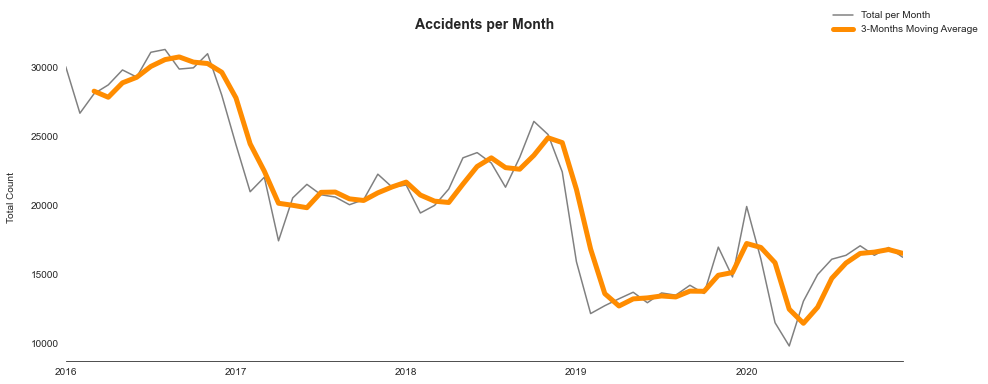

In [13]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,6))

# plot
df.set_index('date').resample('M').size().plot(label='Total per Month', color='grey', ax=ax)
df.set_index('date').resample('M').size().rolling(window=3).mean()\
                           .plot(color='darkorange', linewidth=5, label='3-Months Moving Average', ax=ax)

ax.set_title('Accidents per Month', fontsize=14, fontweight='bold')
ax.set(ylabel='Total Count\n', xlabel='')
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)

# remove all spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False);

**The end of each year is a high accident period and the total number of traffic accidents decreases each year**

As the graph shows, the high incidence of traffic accidents is concentrated at the end of each year, with a downward trend in the number of accidents from the end of the year to the beginning of the following year. This suggests that the increase or decrease in traffic accidents is likely to be related to the holidays at the end of each year. At the same time, the overall trend is that the accidents are decreasing year on year. This indicates that the overall safety situation on the roads is gradually improving.






**Accidents by Times and Weekdays**

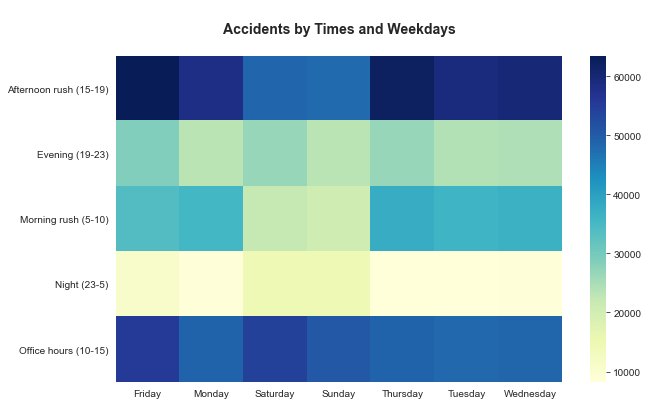

In [14]:
# Define day_of_week
df['day_of_week']=df['date'].dt.day_name()


weekday_counts = pd.DataFrame(df.set_index('date').resample('1d')['accident_index'].size().reset_index())
weekday_counts.columns = ['date', 'Count']
weekday_counts['day_of_week']=weekday_counts['date'].dt.day_name()
weekday = weekday_counts['date'].dt.day_name()

# Calculate average accident in weekday
weekday_averages = pd.DataFrame(weekday_counts.groupby(weekday)['Count'].mean().reset_index())
weekday_averages.columns = ['Weekday', 'Average_Accidents']

# Redefine new dataframe
weekday = df['date'].dt.day_name()
Daytime = df['Daytime']


accident_table = df.groupby([Daytime, weekday]).size()
accident_table = accident_table.rename_axis(['Daytime', 'Weekday'])\
                               .unstack('Weekday')

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(accident_table,cmap="YlGnBu")
plt.title('\nAccidents by Times and Weekdays\n', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('');

**The afternoon rush and office hours are the most accident-prone times of the day, with the Friday afternoon peak often being the most accident-prone time of the week.**

The heat map shows significantly fewer crashes during the afternoon rush hour on weekends than on weekdays, while there are substantially more crashes on weekend evenings than on weekdays. More people go out in the evenings on weekends, and people have more nightlife than on weekdays, so there are more traffic accidents at Night on weekends than on weekdays.

##  3.2 Who is more likely to be involved in a traffic accident?
In this section, we depicted portraits of drivers and casualties in the traffic accident. 


In [15]:
# Get a new dataset about driver and caculate accident number
drivers = df.groupby(['age_band_of_driver', 'sex_of_driver']).size().reset_index()
drivers['Type']='Driver'
drivers.columns = ['Age_Band', 'Sex', 'Count','Type']

# Get a new dataset about casualty and caculate accident number
casualty = df.groupby(['age_band_of_casualty', 'sex_of_casualty']).size().reset_index()
casualty['Type']='Causualty'
casualty.columns = ['Age_Band', 'Sex', 'Count','Type']

# Merge date
aas = pd.concat([casualty, drivers], axis=0)

aas['index']=list(range(0,78,1))
aas.set_index('index', inplace=True)

# Data clean
aas.reset_index(level=None, drop=False, inplace=True)
aas.drop(aas[(aas['Age_Band'] == 'Data missing') | \
                     (aas['Sex'] == 'Unknown') | \
                     (aas['Sex'] == 'unknow') | \
                     (aas['Sex'] == 'Data missing')| \
                     (aas['Sex'] == 'Data missiong')]\
                     .index, axis=0, inplace=True)
#display(aas)

# Plot
fig = px.bar(aas, x="Age_Band", y="Count", color="Type", barmode="group", facet_col="Sex",
            category_orders={"Age_Band": ["0-5", "6-10","11-15", "16-20", "21-25",
                                                    "26-35","36-45","46-55","56-65","66-75","Over 75"],
                             "Sex": ["Male", "Female"]})

fig.show()


# Caculate
# https://www.statista.com/statistics/281240/population-of-the-united-kingdom-uk-by-gender/
# https://www.statista.com/statistics/314886/percentage-of-adults-holding-driving-licences-england/
sod = df.groupby(['sex_of_driver']).size().reset_index()
sod.loc[sod['sex_of_driver']=='Female']
f_2 = 352527/(33.94*1000000*0.70)
print('probability of a female driver being involved in a crash:'+'percent: {:.2f}%'.format(f_2*100))

sod.loc[sod['sex_of_driver']=='Male']
f_3 = 788352/(33.15*1000000*0.81)
print('probability of a male driver being involved in a crash:'+'percent: {:.2f}%'.format(f_3*100))

soc = df.groupby(['sex_of_casualty']).size().reset_index()
soc_p = soc.iloc[2,1]/(soc.iloc[2,1]+soc.iloc[1,1])
print('percentage of male casualties:'+'percent: {:.2f}%'.format(soc_p*100))

probability of a female driver being involved in a crash:percent: 1.48%
probability of a male driver being involved in a crash:percent: 2.94%
percentage of male casualties:percent: 59.12%


**Males are more likely to be involved in traffic accidents than females. Male drivers are twice as likely as female drivers to be involved in a traffic accident. 70% of the casualties were men.** 

In 2020, the population of the United Kingdom was over 67 million, with 33.94 million females and 33.15 million males, which means that the number of males and females is well balanced in the UK. According to Statista, there is an 11% gap, with 81% of men holding a licence and 70% women. Therefore, we can calculate that the probability of a female driver being involved in a crash is 1.5%(352527/[33.94million*70%]), compared to 2.9%(788352/[33.15million*81%]) for male drivers over the past five years.

As for casualties, the number of male casualties was 726,276( 59.12%) and 502,263 female casualties. 


In [16]:
# Get new dataset about driver and casualty 
drivers2 = df.groupby(['age_of_driver']).size().reset_index()
casualty2 = df.groupby(['age_of_casualty']).size().reset_index()
drivers2['Type'] = 'Driver'
casualty2['Type'] = 'Casualty'

# Rename column
drivers2.columns = ['Age','Number','Type']
casualty2.columns = ['Age','Number','Type']

# Merge data
age = pd.concat([drivers2, casualty2], axis=0)

# Drop missing value(-1)
age = age.loc[age['Age'] != -1]

# Plot
fig = go.Figure()
fig = px.scatter(age, x="Age", y="Number", color='Type',marginal_x="histogram", marginal_y="rug")
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))# Add range slider
fig.update_layout(title='Age distribution of traffic accident driver and casualty')
fig.show()

# Caculate
poa1 = age.loc[age['Age']==16]
poa2 = age.loc[age['Age']==18]

poa3 = (poa2.iloc[0,1]-poa1.iloc[0,1])/poa1.iloc[0,1]
poa4 = (poa2.iloc[1,1]-poa1.iloc[1,1])/poa1.iloc[1,1]
print('Multiplier for the increase in the number of drivers involved:',poa3)
print('Percentage increase in the number of traffic casualties between the ages of 16 and 18:'+'percent: {:.2f}%'.format(poa4))

Multiplier for the increase in the number of drivers involved: 4.603417944207087
Percentage increase in the number of traffic casualties between the ages of 16 and 18:percent: 1.14%


**Thirty-year-olds are most likely to be involved in traffic accidents and become victims. Young people who have just received their driver's licence need to stay alert.**

The age of 16-18 and 30 are the two cut-off points that signal a significant increase and decrease in the likelihood of a traffic accident, respectively. 

The number of traffic accidents and casualties increased significantly between the ages of 16-18, with the number of casualties rising from 13.39k to 28.64k, an increase of **114%**, and the number of drivers involved increasing from 3.98k to 22.3k, an increase of **4.6** times. Because young people in the UK can take the test to obtain a legal driver's licence at age 16, the increase in the sample base also led to a significant increase in the number of 16-18 year old drivers involved in traffic accidents. At the same time, 18-year-olds in the UK can drink alcohol legally. Drunk driving is the leading cause of traffic accidents and exacerbates their severity.


## 3.3 Under what circumstances are traffic accidents more likely to occur?

### 3.3.1 Weather Condition: accidents in foggy days are more severe

In [17]:
df1=df1.replace(0,np.nan)
weather = df1.pivot_table(values="accident_index", index="accident_severity", columns="weather_conditions",aggfunc = 'count')
weather.columns = ['Data missing','Fine no high winds',
                   'Raining no high winds','Snowing no high winds',
                   'Fine + high winds','Raining + high winds',
                   'Snowing + high winds','Fog or mist','Other','Unknown']
weather.drop(['Data missing','Unknown'],axis=1, inplace=True)
weather.reset_index(level=None, drop=False, inplace=True)
weather.set_index('accident_severity', inplace=True)
weather2 = weather
w = weather.T.values.tolist()
w2 = weather2.T.values.tolist()

for i in range(6,8):
    sum = w[i][1]+w[i][2]+w[i][0]
    w[i][0]=w[i][0]/sum
    w[i][1]=w[i][1]/sum
    w[i][2]=w[i][2]/sum

for i in range(0,3):
    for j in range(0,3):
        w[i][j]=w[i][j]+w[i+3][j]      
    sum = w[i][1]+w[i][2]+w[i][0]
    w[i][0]=w[i][0]/sum
    w[i][1]=w[i][1]/sum
    w[i][2]=w[i][2]/sum

for i in [0,3]:
    for j in range(0,3):
        w2[i][j]=w2[i][j]+w2[i+1][j]+w2[i+2][j]    
    sum = w2[i][1]+w2[i][2]+w2[i][0]
    w2[i][0]=w2[i][0]/sum
    w2[i][1]=w2[i][1]/sum
    w2[i][2]=w2[i][2]/sum

weather = pd.DataFrame(w).T
weather2 = pd.DataFrame(w2).T
weather.columns = ['Fine','Raining','Snowing',
                   'Fine + high winds','Raining + high winds','Snowing + high winds',
                   'Fog or mist','Other']
weather2.columns = ['No winds','Raining','Snowing',
                   'High Winds','Raining + high winds',
                   'Snowing + high winds','Fog or mist','Other']
weather = weather.T
weather2 = weather2.T
weather.drop(['Fine + high winds','Raining + high winds','Snowing + high winds','Other'],axis=0, inplace=True)
weather2.drop(['Raining','Snowing',
               'Raining + high winds','Snowing + high winds',
               'Fog or mist','Other'],axis=0, inplace=True)

weather=pd.concat([weather, weather2], axis=0)
weather.reset_index(level=None, drop=False, inplace=True)
weather.columns = ['Weather','Fatal','Serious','Slight']
#display(weather)
import plotly.graph_objects as go

fig = go.Figure(
    go.Bar(x=[["Weather","Weather","Weather","Weather","Wind","Wind"],
              ['Fine','Raining','Snowing','Fog or mist','No winds','High Winds']],
           y=weather['Fatal'], 
           name='Fatal'))
fig.add_trace(go.Bar(x=[["Weather","Weather","Weather","Weather","Wind","Wind"],
              ['Fine','Raining','Snowing','Fog or mist','No winds','High Winds']],
                     y=weather['Serious'], name='Serious'))
fig.add_trace(go.Bar(x=[["Weather","Weather","Weather","Weather","Wind","Wind"],
              ['Fine','Raining','Snowing','Fog or mist','No winds','High Winds']],
                     y=weather['Slight'], name='Slight'))

fig.update_layout(barmode='stack',title_text="The severity of traffic accidents in different weather")
fig.update_xaxes(showgrid=True, ticks="outside", tickson="boundaries",categoryorder='array')
fig.update_yaxes(showgrid=True, ticks="outside", tickson="boundaries",categoryorder='array')
fig.show()

**Serious and fatal accidents are more likely to occur on foggy or mist and high winds days. Serious traffic accidents are more likely to occur on sunny days than on rainy or snowy days.**
 
Here, we divide weather conditions into two categories: meteorological and wind. As expected, severe or fatal traffic accidents are more likely to occur on fog or mist days in meteorological conditions. However, contrary to our expectations, the number of accidents on fine days is higher than on rainy and snowy days. The accidents are often more severe, with a percentage of 20%, 19%, and 16% each. That's because, on sunny days, people tend to be subjectively more careless, getting distracted by scenery nearby. In contrast, people will be more careful on rainy and snowy days at a lower driving speed in a relaxed mood.
 


### 3.3.2 Road Condition: 
20, 30, 40, 50, 60, 70 are the only valid speed limits on public highways

In [18]:
# Get a new dataset about road condition and calculate accident 
ss1 = pd.pivot_table(df,index=['road_type','light_conditions','speed_limit'],
                values=['number_of_vehicles','number_of_casualties'],aggfunc='sum')
ss1=ss1.reset_index()

# Data clean
ss1.drop(ss1[(ss1['road_type'] == 'Unknown') | \
                     (ss1['light_conditions'] == 'Unknown')]\
                     .index, axis=0, inplace=True)

# Plot
fig1 = px.scatter_polar(ss1, r="speed_limit", theta="road_type",
                      color="light_conditions", size="number_of_casualties",
                      color_discrete_sequence=px.colors.sequential.Plasma_r)
fig1.show()

ll = df.pivot_table(values="accident_index", index=["light_conditions",
                                                    "accident_severity"],aggfunc = 'count')

ll['percentage%']=ll.groupby(level=0).apply(lambda x:100*x/x.sum())

ll.head()

accident_index  percentage%
light_conditions            accident_severity                             
Darkness - lighting unknown Fatal                         330     1.472360
                            Serious                      3286    14.661134
                            Slight                      18797    83.866506
Darkness - lights lit       Fatal                        4145     1.706534
                            Serious                     44614    18.367986

array([<AxesSubplot:ylabel='counts'>], dtype=object)

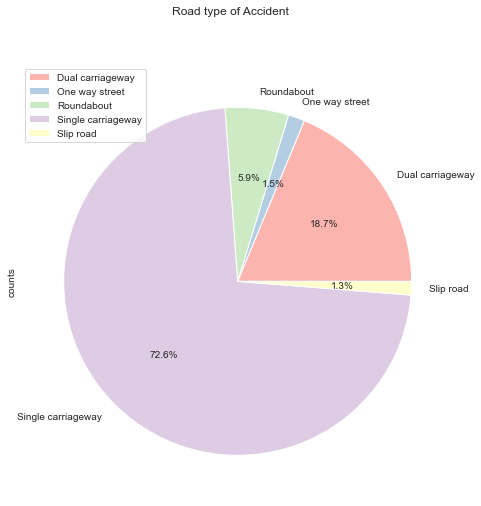

In [19]:
# Get a new dataset about road type
road = df.groupby('road_type').size()\
                                           .reset_index(name='counts')# calculate accident count

# Data clean
road.drop(road[(road['road_type'] == 'Data missing or out of range') | \
                     (road['road_type'] == 'Unknown')]\
                     .index, axis=0, inplace=True)


road=road.set_index('road_type')
from random import shuffle

# Plot
slices = [10,20,30,40]*2  
shuffle(slices)
cmap = plt.cm.Pastel1
colors = cmap(np.linspace(0., 1., len(slices)))

road.plot.pie(figsize=(8, 8),colors=colors,autopct='%1.1f%%',subplots=True, shadow = False,
              title='Road type of Accident')

**The dual carriageway is more prone to fatal traffic accidents. Nighttime lighting reduces the severity of traffic accidents. Traffic accidents get more severe when they exceed a higher speed limit**

A single-carriageway has more traffic accidents than a dual carriageway among the different road types. Of the 91,726 traffic accidents on the dual carriageway, 1.73% were fatal accidents with the highest percentage. In a roundabout, the probability of having a severe traffic accident is 0.36%. Because there are vehicles from both ends of the road in the dual carriageway, and when two cars are crashing towards each other, it is easy to produce a strong rush impact. However, in a single carriageway, the possibility of a slight accident is the least (79.3%); however, in slip road, a slight accident is the most (90.2%). This is because speeds tend to be higher on the single carriageway, while speed limits are set on the slip road. Reducing the driving speed will reduce the accident's impact, thus mitigating the accident.

Of the 20,744 accidents in the no lighting environment, 4.75% were severe, compared with 1.1% of the 428,051 accidents in daylight. 72% of accidents occurred during the day because more people and cars travel during the day; 20% of the number of accidents occurred in the unlit environment. Therefore, the severity of traffic accidents can be reduced by adjusting the brightness of lights at Night.

60% of traffic accidents occur on roads with a speed limit of 30miles/hour, and 13 per cent of traffic accidents occur on roads with a speed limit of 60miles/hour. Because roads with speed limits of 30miles/hour are often sharp curves, broken roads and arch bridges, drivers and pedestrians are often too inflexible to make new judgments in these places with special topography and are more likely to have traffic accidents. Suppose traffic accidents occur in areas with higher speed limits. In that case, traffic accidents tend to be more serious; the proportion of serious traffic accidents with a speed limit of 60 miles/hour is 3.6%. In traffic accidents with a speed limit of 20, the ratio of serious is only 0.48%.



###  3.3.3 Junction Conditions:

In [20]:
# Get a new dataset about junction condition
jc = df.pivot_table(values="accident_index", index=["junction_detail",
                                                    "junction_control"],aggfunc = 'count')# caculate count of accident 

# Data cleaning
jc=jc.reset_index()
jc.drop(jc[(jc['junction_detail'] == 'NoData') | \
                     (jc['junction_detail'] == 'NoData2') | \
                     (jc['junction_control'] == 'Not at junction or within 20 metres') | \
                     (jc['junction_control'] == 'NoData')  | \
                     (jc['junction_control'] == 'NoData2')]\
                     .index, axis=0, inplace=True)

#plot
fig = px.bar_polar(jc, r="accident_index", theta="junction_detail", color="junction_control", #line_close=True,
                   color_discrete_sequence=px.colors.sequential.Plasma_r)
                  
fig.show()

cc = df.pivot_table(values="accident_index", index=["junction_detail",
                                                    "accident_severity"],aggfunc = 'count')

cc['percentage%']=cc.groupby(level=0).apply(lambda x:100*x/x.sum())

cc.head()          

accident_index  percentage%
junction_detail accident_severity                             
Crossroads      Fatal                        1307     1.054943
                Serious                     20677    16.689401
                Slight                     101909    82.255656
Mini-roundabout Fatal                          29     0.203409
                Serious                      1921    13.474083

**58% of accidents occur at intersections, 50% of which occur at T or staggered junction; stop signs and authorized persons can help reduce the number of accidents**

58% of accidents occur at intersections, 42% of accidents not at junctions or within 20 metres. Intersections are hubs of road traffic, and traffic flows in different directions from more conflict points and interweaving points at intersections. Drivers are often distracted from driving at intersections because they think about their travel route. As a result, intersections tend to be a high incidence point for traffic accidents. Of all accidents, 30% occur at T or staggered junctions, 9.5% at crossroads, and 8.2% at roundabouts, so extra care is needed when approaching these two types of intersections. In the slip road, when driving downhill, the driver often takes the operation method of turning off the engine and coasting to save fuel. In an emergency, it is too late to take emergency measures.

45% of accidents occur at give way or uncontrolled junctions, 11% at auto traffic signals, 0.6% at junctions with a stop sign, and only 0.3% at intersections with an authorized person. Therefore, to some extent, installing a stop sign at a junction can effectively prevent traffic accidents.




## 3.4 Spatial Analysis: In which cities or regions traffic accidents occur more frequently?


### 3.4.1 Cities: London and Birmingham have the highest number of traffic accidents

In [21]:
#import the json fill
u1 = open("Local_Authority_Districts_(December_2020)_UK_BFC.json")
uk_districts = json.load(u1)

# import the index file from the Road Safety Open-Dataset-Data-Guide
index = pd.read_excel("https://data.dft.gov.uk/road-accidents-safety-data/Road-Safety-Open-Dataset-Data-Guide.xlsx")

In [22]:
# Data cleaning - index
index2=index.loc[index['field name'] == "local_authority_district"]
dis = df1.pivot_table(values="accident_index", 
                          #index="accident_year", 
                      columns="local_authority_district",aggfunc = 'count')
#dis = df[['accident_index','local_authority_district','accident_year']] 
#dis
dis2 = dis.T
dis2.reset_index(level=None, drop=False, inplace=True)
dis3=pd.merge(dis2,index2,how="inner",left_on="local_authority_district",right_on="code/format")
#dis3

#Here we can use the column "label" in the clean data and "LAD20NM" in the feature properties
fig = px.choropleth_mapbox(dis3, locations="label", featureidkey="properties.LAD20NM", 
                           geojson=uk_districts, color="accident_index", hover_name="label", 
                           color_continuous_scale=px.colors.sequential.deep,
                           mapbox_style="carto-positron", zoom=4, center = {"lat": 55, "lon": 0})
fig.show()

By zooming in on the interactive map, we can see a black dot on the graph that represents the highest number of traffic accidents in this location in the last five years combined - 12.55k people. This is Birmingham, the second-largest city in the UK besides London. Because the number of accidents is divided by authority districts, it is impossible to show the enormous number of accidents in London as a whole. However, the number of accidents in London is the highest in the UK, as seen from the borough data alone. Meanwhile, Leeds, Cornwall and Wiltshire also have more traffic accidents.


###  3.4.2 Cluster analysis : Locate accident hotspots in the Central London
This section used clustering (DBSCAN) to identify accident hotspots in central London in 2020. DBSCAN groups point that are densely packed together and marks points outside of these groups as noise. Therefore, locations with high accident densities will be highlighted as clusters using this algorithm. We then use folium to plot the locations of these clusters. 

1. First, we need to filter the data we need.

2. As DBSCAN needs to use an indicator when calculating the distance between points. We create a function that takes the latitude and longitude of two points and calculates the distance (in metres) between them.

3. To ensure that the earth's curvature is taken into account when calculating the distance, we also created geopy's great_circle function.




In [23]:
cluster=df[['latitude','time','longitude','accident_year','date','number_of_vehicles','number_of_vehicles','local_authority_highway']]
cluster=cluster[cluster['accident_year']==2020]
City = cluster[cluster['local_authority_highway'] == 'E09000001']

dfnew = pd.concat([City], axis = 0)

In [26]:
# Ensure that the curvature of the Earth is taken into account when calculating these distances
def greatcircle(x,y):
    lat1, long1 = x[0], x[1]
    lat2, long2 = y[0], y[1]
    dist = great_circle((lat1,long1),(lat2,long2)).meters
    return dist
# Determines the maximum distance between two samples for one to be considered as in the neighborhood of the other

eps = 100 #distance in meters
min_samples = 10

df_dbc = dfnew

loc = df_dbc[['latitude','longitude']]

# DBSCAN groups points that are closely packed together and marks points outside of these groups as noise
dbc = DBSCAN(eps = eps, min_samples = min_samples, metric=greatcircle).fit(loc)

labels = dbc.labels_

df_dbc['Cluster'] = labels

location = df_dbc['latitude'].mean(), df_dbc['longitude'].mean()

#plot
m = folium.Map(location=location,zoom_start=13)

folium.TileLayer('cartodbpositron').add_to(m)

clust_colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

for i in range(0,len(df_dbc)):
    colouridx = df_dbc['Cluster'].iloc[i]
    if colouridx == -1:
        pass
    else:
        col = clust_colours[colouridx%len(clust_colours)]
        folium.CircleMarker([df_dbc['latitude'].iloc[i],df_dbc['longitude'].iloc[i]], radius = 10, color = col, fill = col).add_to(m)

m

**The traffic accident cluster is most remarkable near Liverpool Street Station and Monument Station in central London.**

In city of London, there are five accident hotspots clusters, each shown in a different colour.

From left to the right in the above figure, the light blue cluster includes the junction of Charterhouse St., West Smithfield, and Fairingdon St., near Holborn and LSE. The light green cluster is at the intersection of Londonwall and Moorgate. Pink cluster locates on the crossroads of Cannon St., Kings William St., and Grace Church St. Grass green cluster locates on the Bishopsgate St., Wormwood St., and Camomole St, near Liverpool St. Station, where the trend towards agglomeration is most evident. Navy cluster mainly locates on the Aldgate High St.

All clusters are located in popular, crowded areas, especially near T-roads, intersections, and metro stations.

## 3.5 ARIMA: Covid accelerates reduction in the number of traffic accidents

**Visualize Covid Data**

In [27]:
import plotly.graph_objects as go
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=covid['date'], y=covid['deathNew'], name = 'New death cases',
                        line=dict(color='#FF9900', width=2)))
fig.add_trace(go.Scatter(x=covid['date'], y=covid['latestBy'], name = 'Latest By',
                        line=dict(color='#3366CC', width=2)))
fig.add_trace(go.Scatter(x=covid['date'], y=covid['death'], name = 'Death cases',
                        line=dict(color='#109618', width=2)))
fig.add_trace(go.Scatter(x=covid['date'], y=covid['confirmed'], name = 'New confirmed cases',
                        #mode='lines+markers',
                        line=dict(color='#FECB52', width=2)))

# Add range slider
fig.update_layout(
   xaxis=dict(
       rangeselector=dict(
           buttons=list([
               dict(count=1,
                    label="1m",
                    step="month",
                    stepmode="backward"),
               dict(count=6,
                    label="6m",
                    step="month",
                    stepmode="backward"),
               dict(count=1,
                    label="YTD",
                    step="year",
                    stepmode="todate"),
               dict(count=1,
                    label="1y",
                    step="year",
                    stepmode="backward"),
               dict(step="all")])),
       rangeslider=dict(visible=True),
       type="date"))

fig.update_layout(title='Covid data')
fig.update_yaxes(title='Number')
fig.update_xaxes(title='Date')

**In March 2020, the Covid-19 epidemic began to spread in the UK.**

Since March 2020, the number of new cases and deaths of the Covid-19 epidemic in the UK has started to rise. Some people have started to work from home and reduce their daily travel.

**Tips:** 
After clicking on the new confirmed case in the legend, this curve will be cancelled. As a result, the images of the other three data sets will be more visible.

**Monthly Trend**

**Step1:** Extract the average number of accidents in each month. Visualise the data using time-series decomposition that allows us to decompose our time series into three distinct components:

This part aims to predict the number of future road accidents in the UK by implementing time Series forecasting methods – ARIMA. ARIMA stands for Auto-Regressive Integrated Moving Average. There are seasonal and Non-seasonal ARIMA models that can be used for forecasting. 3 terms characterize an ARIMA model: p, d, q where p is the order of the AR term, q is the order of the MA term, and d is the number of differences required to make the time series stationary. If a time series has seasonal patterns, you need to add seasonal terms, and it becomes SARIMA, short for ‘Seasonal ARIMA’. More on that once we finish ARIMA.

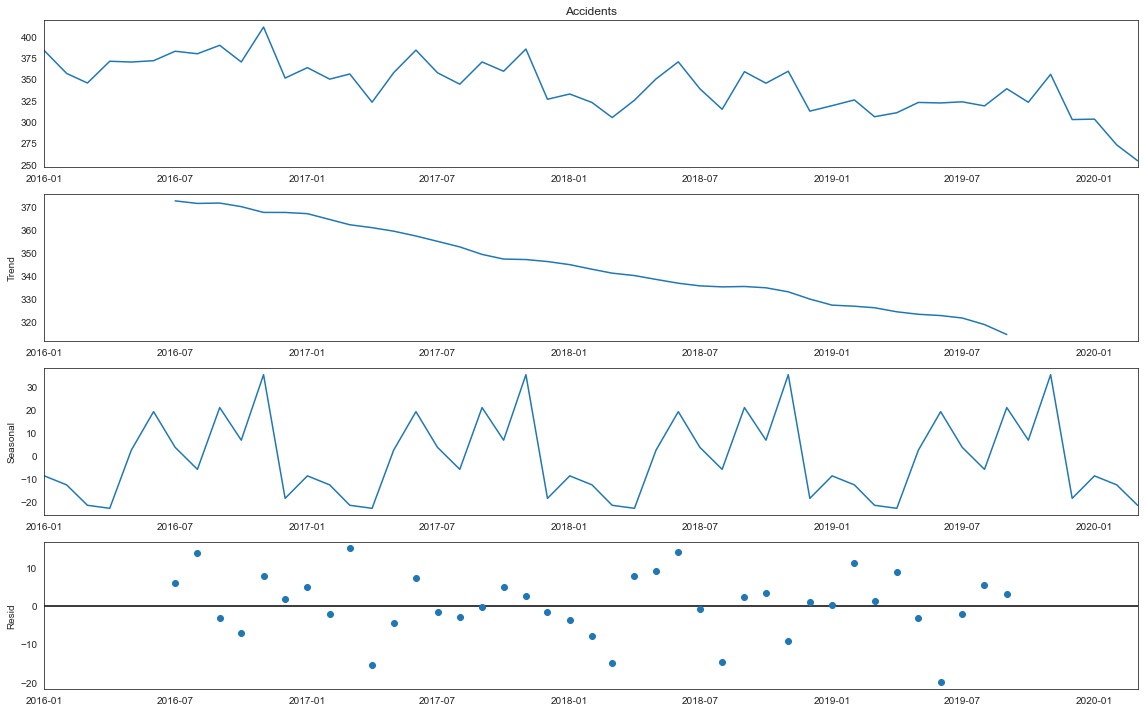

In [28]:
y = aa_bc['Accidents'].resample('MS').mean()
rcParams['figure.figsize'] = 16, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

**Step 2:** Fitting the ARIMA Model. Below are the examples of parameter combinations for seasonal ARIMA. This step is parameter Selection for our ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [29]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter combinations for Seasonal ARIMA...')
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            #results = mod.fit()
            
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])

**Step3:** Evaluation of forecasts: In order to understand the accuracy of our forecasts, we compare predicted number of accidents to the real number of accidents of the time series, and we set forecasts to start at 2017–01–01 to the end of the data. Find out the MSE to see the accuracy of our model. The mean squared error (MSE) is largely used as a metric to determine the performance of an algorithm. In addition, MSE is the average of the square of the difference between the observed and predicted values of a variable.

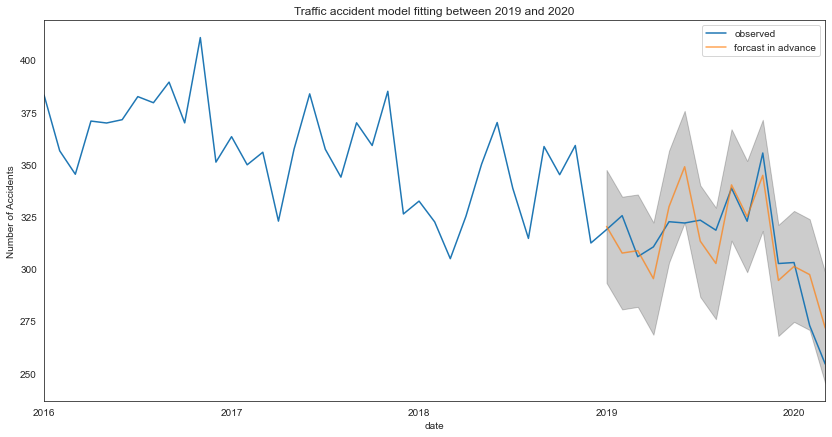

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False) 
pred_ci = pred.conf_int() 
ax = y['2016-01-01':].plot(label='observed') 
pred.predicted_mean.plot(ax=ax, label='forcast in advance', alpha=.7, figsize=(14, 7)) 
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2) 
ax.set_xlabel('date') 
ax.set_ylabel('Number of Accidents') 
ax.set_title('Traffic accident model fitting between 2019 and 2020')
plt.legend() 
plt.show()

The orange and blue lines overlap well with each other, representing a good model fit.

**Step 4:** Visualising Forecasts. We set the step to 21, means the model will predict the number of next 21 months. As we can see in the below graph the number of road accident in UK will be declined until the end of 2021.

The Mean Squared Error of our forecasts is 185.4


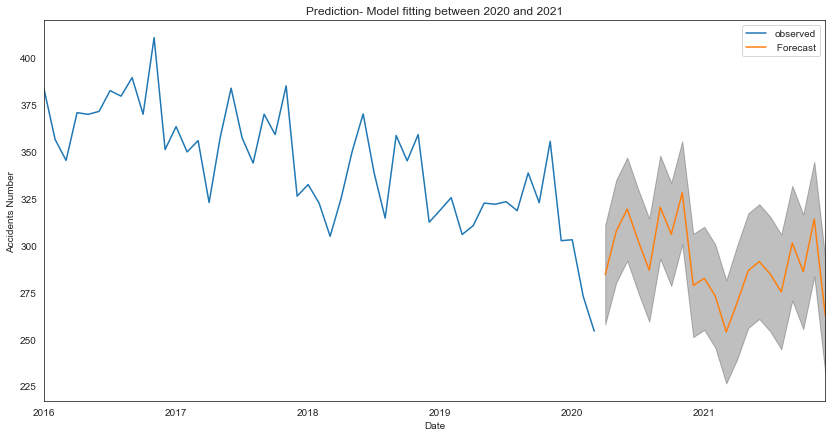

In [31]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

pred_uc = results.get_forecast(steps=21) 
pred_ci = pred_uc.conf_int() 
ax = y.plot(label='observed', figsize=(14, 7)) 
pred_uc.predicted_mean.plot(ax=ax, label=' Forecast') 
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='k', alpha=.25) 
ax.set_xlabel('Date') 
ax.set_ylabel('Accidents Number') 
ax.set_title('Prediction- Model fitting between 2020 and 2021')
plt.legend() 
plt.show()
a_p = pd.DataFrame(pred_uc.predicted_mean)

In [32]:
a_p.reset_index(level=None, drop=False, inplace=True)
a_p.columns = ['Date','predicted_mean']
a_p['Date'] =a_p['Date'].apply(lambda x: pd.to_datetime(x).strftime('%Y-%m'))
aa = aa.set_index(['Date'],drop=True)
aa = aa.resample('M',closed = 'left').mean()
aa.reset_index(level=None, drop=False, inplace=True)
aa['Date'] =aa.Date.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m'))

In [33]:
import plotly.graph_objects as go
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=aa['Date'], y=aa['Accidents'], name='Actual Accident(Monthly)',
                         mode='lines+markers',
                        line=dict(color='firebrick', width=3)))
fig.add_trace(go.Scatter(x=a_p['Date'], y=a_p['predicted_mean'], name = 'Predicted Accident(Monthly)',
                         mode='lines+markers',
                        line=dict(color='royalblue', width=3, dash='dot')))


# Add range slider
fig.update_layout(
   xaxis=dict(
       rangeselector=dict(
           buttons=list([         
               dict(count=1,
                    label="1y",
                    step="year",
                    stepmode="backward"),
               dict(count=2,
                    label="2y",
                    step="year",
                    stepmode="backward"),
               dict(count=3,
                    label="3y",
                    step="year",
                    stepmode="backward"),
               dict(step="all")])),
       rangeslider=dict(visible=True),
       type="date"))
fig.update_layout(title='Monthly Actual Number and Predicted Number of Accidents')
fig.update_yaxes(title='Number of Accidents')
fig.update_xaxes(title='Date')
fig.show()

**After the occurrence of the Covid, the traffic accidents accelerated to decrease.**

Here, we use traffic accident data from March 2020 (before the outbreak of Covid-19) as a sample and use an ARIMA model to predict and compare them with actual values.

After the occurrence of the Covid, the traffic accidents accelerated to decrease. In the graph, all monthly forecasts (blue dashed line) are higher than the true values (solid red line). This is especially true for April 2020, February 2021, and October-November 2021. This is because strict quarantine policies enacted by the government or Omicron emerged and spread widely during this time, causing people to reduce their travel activities and thus reduce traffic accidents. The next graph shows the relationship between covid and traffic accident data more clearly.



**Daily Trend**

In [34]:
y = aa_bc['Accidents'].resample('D').mean()
rcParams['figure.figsize'] = 16, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter combinations for Seasonal ARIMA...')
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            #results = mod.fit()
            
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False) 
pred_ci = pred.conf_int() 

y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

pred_uc = results.get_forecast(steps=627) # predict the number in the next 640 days
pred_ci = pred_uc.conf_int() 
a_pd = pd.DataFrame(pred_uc.predicted_mean)
a_pd.reset_index(level=None, drop=False, inplace=True)

The Mean Squared Error of our forecasts is 5215.3


In [35]:
import plotly.graph_objects as go
fig = go.Figure()

# Create and style traces
fig.add_trace(go.Scatter(x=covid['date'], y=covid['deathNew'], name = 'New death cases',
                        line=dict(color='#7f7f7f', width=1)))
fig.add_trace(go.Scatter(x=a_pd['index'], y=a_pd['predicted_mean'], name = 'Predicted Accident(Daily)',
                        line=dict(color='royalblue', width=1, dash='dash')))
fig.add_trace(go.Scatter(x=aa['Date'], y=aa['Accidents'], name='Actual Accident(Daily)',
                        line=dict(color='firebrick', width=2)))

# Add range slider
fig.update_layout(
   xaxis=dict(
       rangeselector=dict(
           buttons=list([
               dict(count=1,
                    label="1m",
                    step="month",
                    stepmode="backward"),
               dict(count=6,
                    label="6m",
                    step="month",
                    stepmode="backward"),
               dict(count=1,
                    label="YTD",
                    step="year",
                    stepmode="todate"),
               dict(count=1,
                    label="1y",
                    step="year",
                    stepmode="backward"),
               dict(step="all")])),
       rangeslider=dict(visible=True),
       type="date"))

fig.update_layout(title='Daily Actual Number and Predicted Number of Accidents')
fig.update_yaxes(title='Number of Accidents')
fig.update_xaxes(title='Date')
fig.show()

**New death cases and actual accidents show an inverse variation relationship.**

From April 2020-August 2021, we can see four cycles of New death cases and actual accidents interacting up and down. When New death cases decrease, real daily accidents increase, and vice versa. The convexity of the two curves is always opposite.


## 3.6 Random Forest: Speed limits has the greatest impact on traffic accidents

Here we extract all the variables used above to make more accurate predictions about the factors that affect the severity of traffic accidents using variables such as driver age, junction detail, weather conditions as well as travel time and speed limit conditions.

In [36]:
df['weather_conditions']=df['weather_conditions'].apply(str)
df['weather_conditions'].replace(['1.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','-1.0'],
                                   ['Fine','Raining','Snowing',
                   'Fine + high winds','Raining + high winds','Snowing + high winds',
                   'Fog or mist','Other','Unknown','Data missing',]
                                   ,inplace=True)

num_col = ['speed_limit']
col1=['Daytime','weather_conditions','junction_control','age_band_of_driver'
      ,'junction_detail','road_type','sex_of_driver']
targetcol=['accident_severity']
cols = col1+targetcol+num_col

model = df[cols].copy()
#model.head()

# create dummy variables from the categorical features
dummies = pd.get_dummies(model[col1], drop_first=True)
model = pd.concat([model[num_col], model[targetcol], dummies], axis=1)
#check NaN
print('number of NaN:',model.isna().sum().sum())

number of NaN: 0


**Step 1:** As we are using a tree-based model here, rather than a distance-based one, we can handle different ranges of features. Therefore, scaling is not required. We use the train_test_split function to select train data and test data from the sample at a random proportion (20%).

In [37]:
features = model.drop(['accident_severity'],axis=1) #define feature

target = model[['accident_severity']] #define target


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)


**Step 2:** The advantages of the random forest algorithm in terms of classification effectiveness are its high classification accuracy, low generalisation error and ability to handle high-dimensional data, and the advantages of the training process are the fast learning process and the ease of parallelisation. However, when the distribution of data categories is unbalanced, i.e. the number of sample instances in one category is much smaller than the number of samples in the other categories, the random forest algorithm will have a series of problems such as poor classification results and large generalisation errors. So we need to further check the distribution of data categories


In [38]:
# Checking imbalanced classes
model['accident_severity'].value_counts(normalize=True)

Slight     0.793094
Serious    0.187179
Fatal      0.019727
Name: accident_severity, dtype: float64

**Step 3:** As we can see, we obtained a target with highly imbalanced classes, so we can't apply the best strategy and can't collect more data, especially from minority class. For this case we can use model evaluation metrics that are more appropriate for the unbalanced class: confusion matrix, precision or ROC curve instead of accuracy. Alternatively, we can use the class weight parameter included in some implementations of the model, which allows us to have the algorithm adjust for imbalanced classes. Here we focus on class weight parameters.


In [39]:
forest_1 = RandomForestClassifier(random_state=4, criterion='entropy', n_jobs=-1, class_weight='balanced')

# train
forest_1.fit(X_train, y_train.values.ravel())

# predict
y_test_preds  = forest_1.predict(X_test)

In [40]:
# evaluate
report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest - with Entropy and class_weight Parameter: \n', report)


Classification Report Random Forest - with Entropy and class_weight Parameter: 
               precision    recall  f1-score   support

       Fatal       0.06      0.70      0.12      4908
     Serious       0.25      0.31      0.28     45719
      Slight       0.86      0.59      0.70    195268

    accuracy                           0.54    245895
   macro avg       0.39      0.54      0.37    245895
weighted avg       0.73      0.54      0.61    245895



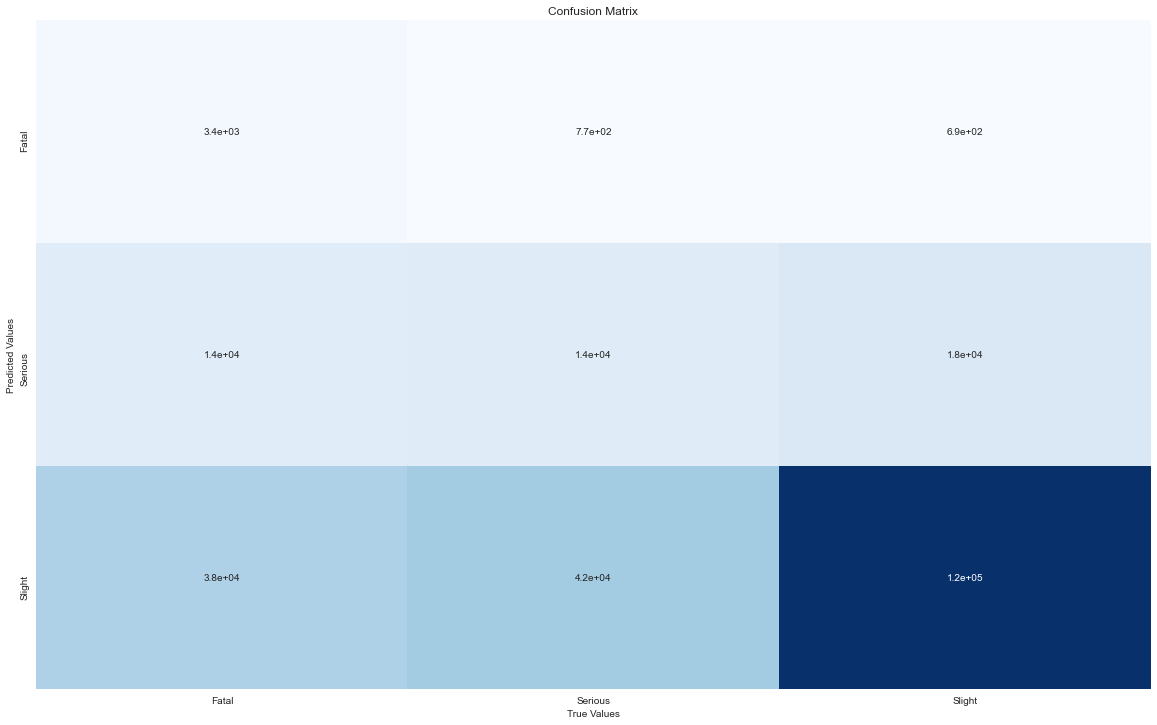

In [41]:
matrix = confusion_matrix(y_test, y_test_preds)

# create dataframe
class_names = model.accident_severity.values
dataframe = pd.DataFrame(matrix, index=['Fatal', 'Serious', 'Slight'], 
                         columns=['Fatal', 'Serious', 'Slight'])

# create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
plt.show()

**Step 4:** We found that random forests using the weight_class parameter did not perform very well in classifying severity levels. Therefore, let us try a resampling strategy to properly handle our unbalanced target classes. Synthetic Minority Over-sampling Technique (SMOTE). Here, we repeatedly sample from a minority class and replace it so that it is equal in size to the majority class.

In [42]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

forest_2 = RandomForestClassifier(random_state=4, criterion='entropy', n_jobs=-1)

In [48]:
# train
forest_2.fit(X_train, y_train.values.ravel())

# predict
y_test_preds = forest_2.predict(X_test)


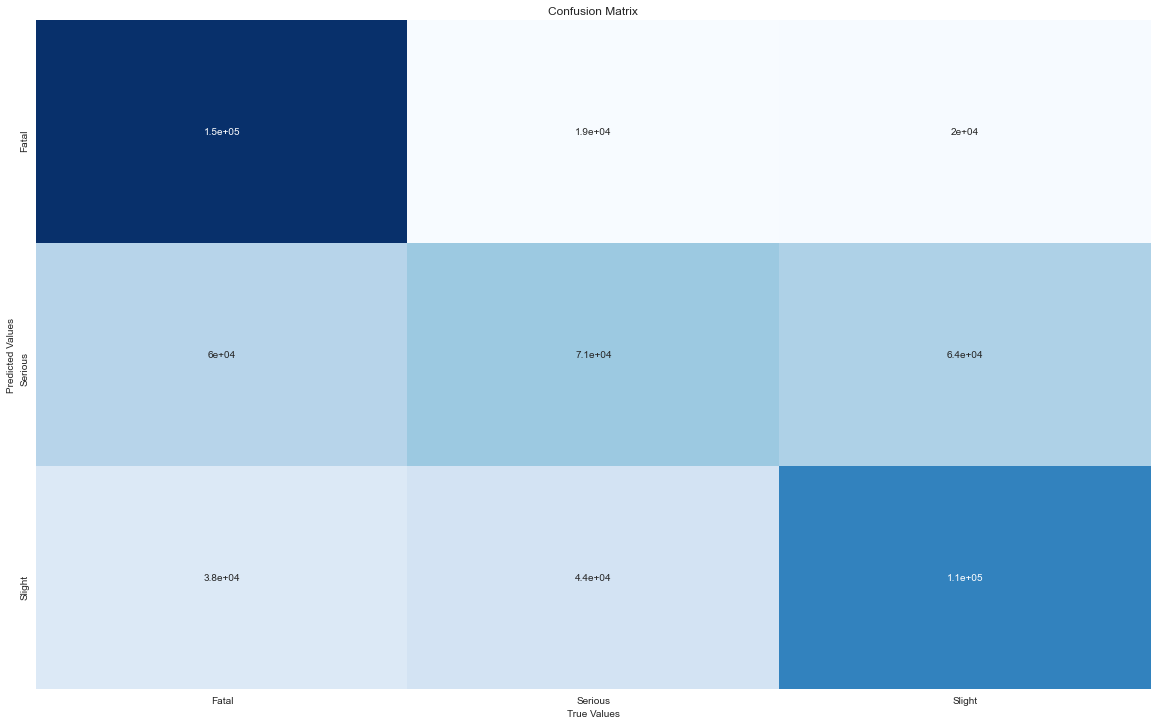

In [49]:
#creat matrix
matrix = confusion_matrix(y_test, y_test_preds)

# create dataframe
class_names = model.accident_severity.values
dataframe = pd.DataFrame(matrix, index=['Fatal', 'Serious', 'Slight'], 
                         columns=['Fatal', 'Serious', 'Slight'])



# create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
plt.show()



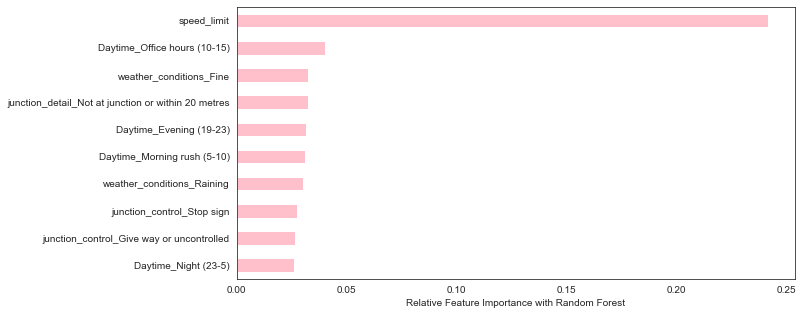

In [50]:
feat_importances = pd.Series(forest_2.feature_importances_, index=features.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='pink', figsize=(10,5))
plt.xlabel('Relative Feature Importance with Random Forest');

In the final result, the relative characteristics of the speed limit are of the highest importance, with office hours second. In real life, excessive driving speeds are often a direct cause of traffic accidents. 
Fine and rainy days have comparatively high relative feature importance in the weather indicator. In the 24 hours of the day, office hours and evening hour traffic accidents are more important.
For policymakers, reducing the severity of traffic accidents can also start with limiting speeds and taking care to divert traffic during peak periods.

# 4. Conclusion

In this project, we first introduced the background and dataset of the study. And we downloaded the data of Road safety and Covid-19 through API and URL. Meanwhile, we loaded the UK-wide base map with the help of the API of Local Authority Districts. Finally, we make the following conclusions.
 
1. Temporal distribution: In 2016-2020, the total number of accidents is highest at the end of each year, with most traffic accidents occurring during the morning and evening rush hours on weekdays.

2. Sex: Unlike the traditional impression, males (2.94%) are more likely to be involved in traffic accidents than females (1.48%), so male drivers are twice as likely as female drivers to be involved in a traffic accident. And 70% of the casualties were men.

3. Age: Thirty-year-olds are most likely to be involved in traffic accidents and become victims. However, after this time, the number of accidents gradually decreases. The age of 16-18 is another cut-off point that signals a significant increase in the likelihood of a traffic accident when reaching the age of legally obtaining driving and alcohol permission. Thus, we would suggest that - young people who have just received their driver's licence need to stay alert.

4. Weather Condition: Serious and fatal accidents are more likely to occur in foggy, mist, and high winds. Serious traffic accidents are more likely to occur on sunny days than rainy or snowy days. So, drivers need to stay calm on sunny days as that old saying tells us - Sing before breakfast, you'll cry before supper.

5. Junction condition: 58% of accidents occur at intersections, 50% of which occur at T or staggered junctions; stop signs and authorised persons can help reduce the number of casualties. From the driver's perspective, before passing through a traffic intersection, it’s supposed to maintain a high concentration level to avoid traffic accidents. From the policy maker's perspective, stop signs and signals should be installed at intersections where accidents are likely to occur. If possible, you can hire an authorised personnel to manage the traffic at the meeting.

6. Spatial Analysis: Two largest cities in the UK - London and Birmingham have the highest traffic accidents. The traffic accident cluster is most remarkable near Liverpool Street Station and Monument Station in central London.

7. Covid and road safety: In March 2020, the Covid-19 epidemic spread in the UK. After the occurrence of the Covid, the traffic accidents accelerated to decrease. New death cases and actual accidents show an inverse variation relationship.

8. Random Forest: among all the indexes in the road safety dataset, the speed limit has the highest relative feature importance.



In [51]:
from wordcloud import WordCloud, STOPWORDS

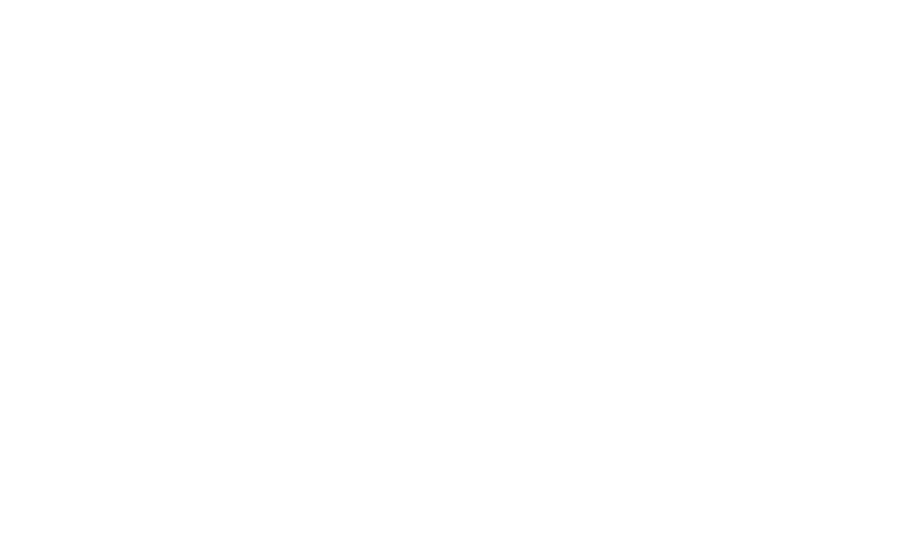

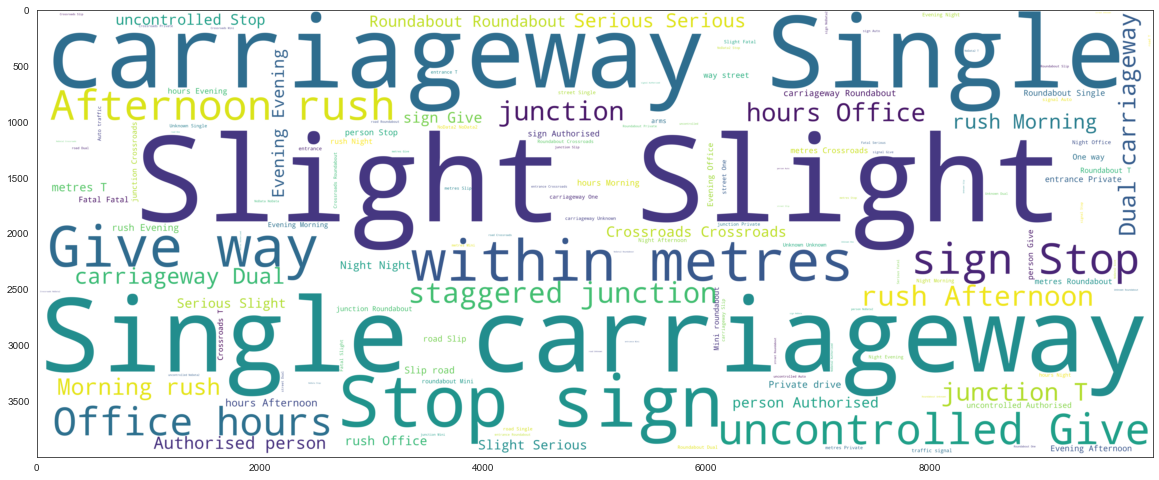

In [52]:
a=df[['accident_severity']]
a.columns = ['Type']
b=df[['road_type']]
b.columns = ['Type']
c=df[['junction_control']]
c.columns = ['Type']
d=df[['junction_detail']]
d.columns = ['Type']
e=df[['Daytime']]
e.columns = ['Type']

word = pd.concat([a,b,c,d,e],axis=0)

text = " ".join(i for i in word.Type)
#print ("There are {} words in the combination of all cells in column BLOOM.".format(len(text)))


wordcloud = WordCloud(background_color="white",scale = 4,
               width=2500, height=1000).generate(text)

# Display the generated image:
# the matplotlib way:

plt.axis("off")
plt.figure(figsize=(20,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud
           ,interpolation='bilinear')
plt.show()